Reference

https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.MinMaxScaler.html

https://www.kaggle.com/code/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html


In [ ]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])
    #print(targets)
    #print(len(sequences))
    #print(len(targets))
    return np.array(sequences), np.array(targets)

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
np.random.seed(2)
torch.manual_seed(2)
torch.use_deterministic_algorithms(True)

In [ ]:
#loading the data
ticker = 'CVX'
start_date = '2000-01-01'
end_date = '2024-01-01'
data = yf.download(ticker, start=start_date, end=end_date)
data = data['Close']
data = data['CVX']
data = data.bfill()

[*********************100%***********************]  1 of 1 completed


In [ ]:
train_end_year = 2018
test_start_date = '2019-01-01'
test_end_date = '2023-01-01'
seq_length = 50
batch_size = 32

In [ ]:
def loadataset(test_start_date, test_end_date):
  train = data[data.index.year <= train_end_year]
  test = data[(data.index >= test_start_date) & (data.index < test_end_date)]
  #print(train.shape)
  #print(train)
  #print(test.shape)
  #all_data = pd.concat([train, test])
  # normalization
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_data = scaler.fit_transform(pd.concat([train, test]).values.reshape(-1, 1))
  train_scaled = scaler.transform(train.values.reshape(-1, 1))
  test_scaled = scaler.transform(test.values.reshape(-1, 1))
  #print(train_scaled)
  #print(test_scaled)
  training_data, training_label = create_sequences(train_scaled, seq_length)
  test_data, test_label = create_sequences(test_scaled, seq_length)
  '''
  print(training_data.shape)
  print(training_label.shape)
  print(test_data.shape)
  print(test_label.shape)
  '''
  '''
  print(training_data)
  print(training_label)
  print(test_data)
  print(test_label)
  '''
  #training_data, training_label = create_sequences(train, seq_length)
  #test_data, test_label = create_sequences(test, seq_length)
  '''
  training_data_tensor = torch.tensor(training_data, dtype=torch.float32)
  training_label_tensor = torch.tensor(training_label, dtype=torch.float32)
  test_data_tensor = torch.tensor(test_data, dtype=torch.float32)
  test_label_tensor = torch.tensor(test_label, dtype=torch.float32)
  '''
  #training_dataset = TensorDataset(training_data_tensor, training_label_tensor)
  #test_dataset = TensorDataset(test_data_tensor, test_label_tensor)
  train_loader = DataLoader(TensorDataset(torch.tensor(training_data, dtype=torch.float32), torch.tensor(training_label, dtype=torch.float32)), batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(TensorDataset(torch.tensor(test_data, dtype=torch.float32), torch.tensor(test_label, dtype=torch.float32)), batch_size=batch_size, shuffle=False)
  '''
  print(train_loader)
  print(test_loader)
  '''
  '''
  print(training_data_tensor)
  print(training_label_tensor)
  print(test_data_tensor)
  print(test_label_tensor)
  '''
  return train_loader, test_loader, scaler, test

In [ ]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        '''
        print(self.lstm)
        print(self.out)
        '''
    def forward(self, x):
        hidden = torch.zeros(2, x.size(0), 50).to(x.device)
        #print(h.shape)
        cell = torch.zeros(2, x.size(0), 50).to(x.device)
        #print(c.shape)
        out, hidden_state = self.lstm(x, (hidden, cell))
        #print(out.shape)
        out = self.out(out[:, -1, :])
        #print(out.shape)
        return out

In [ ]:
# Training
def train(test_start_date, test_end_date,train_loader, test_loader):
  #create the model
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = LSTM().to(device)
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  num_epochs = 15
  for epoch in range(num_epochs):
      model.train()
      training_loss = 0
      # train on batch
      for training_batch, training_label in train_loader:
          #training_batch, training_label = training_batch.to(device), training_label.to(device)
          optimizer.zero_grad()
          outputs = model(training_batch.to(device))
          loss = criterion(outputs, training_label.to(device))
          loss.backward()
          optimizer.step()
          training_loss += loss.item()
          #print(training_loss,'training_loss')
      print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {training_loss/len(train_loader):.4f}")
  return model

In [ ]:
#prediction
def predict(test_start_date, test_end_date, train_loader, test_loader, model, scaler):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.eval()
  predictions = []
  actuals = []
  with torch.no_grad():
      for training_batch, training_label in test_loader:
          #training_batch = training_batch.to(device)
          #outputs = model(training_batch.to(device))
          #print(outputs.shape)
          predictions.append(model(training_batch.to(device)).cpu().numpy())
          actuals.append(training_label.numpy())
  #predictions = np.concatenate(predictions)
  #print(predictions)
  #actuals = np.concatenate(actuals)
  #print(actuals)
  predicted_prices = scaler.inverse_transform(np.concatenate(predictions))
  #print(predicted_prices)
  actual_prices = scaler.inverse_transform(np.concatenate(actuals).reshape(-1, 1))
  #print(actual_prices)
  return predicted_prices, actual_prices

In [ ]:
#ploting the result
def plot(test_start_date, test_end_date, predicted_prices, actual_prices):
  plt.figure(figsize=(14, 9))
  plt.plot(test.index[seq_length:], actual_prices, label='Actual Stock Prices', color='blue')
  plt.plot(test.index[seq_length:], predicted_prices, label='Predicted Stock Prices', color='red')
  plt.title(f'{ticker} Stock Price Prediction (from {test_start_date} to {test_end_date}) with LSTM')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend()
  plt.show()

In [ ]:
def mse(test_start_date, test_end_date, predicted_prices, actual_prices):
  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(actual_prices, predicted_prices)
  print(f"Mean Squared Error: {mse:.4f}")

In [ ]:
train_loader, test_loader, scaler, test=loadataset(test_start_date, test_end_date)

In [ ]:
model=train(test_start_date, test_end_date, train_loader, test_loader)

Epoch 1/15, Training Loss: 0.0197
Epoch 2/15, Training Loss: 0.0004
Epoch 3/15, Training Loss: 0.0003
Epoch 4/15, Training Loss: 0.0003
Epoch 5/15, Training Loss: 0.0003
Epoch 6/15, Training Loss: 0.0003
Epoch 7/15, Training Loss: 0.0003
Epoch 8/15, Training Loss: 0.0002
Epoch 9/15, Training Loss: 0.0003
Epoch 10/15, Training Loss: 0.0002
Epoch 11/15, Training Loss: 0.0002
Epoch 12/15, Training Loss: 0.0002
Epoch 13/15, Training Loss: 0.0002
Epoch 14/15, Training Loss: 0.0002
Epoch 15/15, Training Loss: 0.0002


In [ ]:
predicted_prices, actual_prices=predict(test_start_date, test_end_date, train_loader, test_loader, model, scaler)

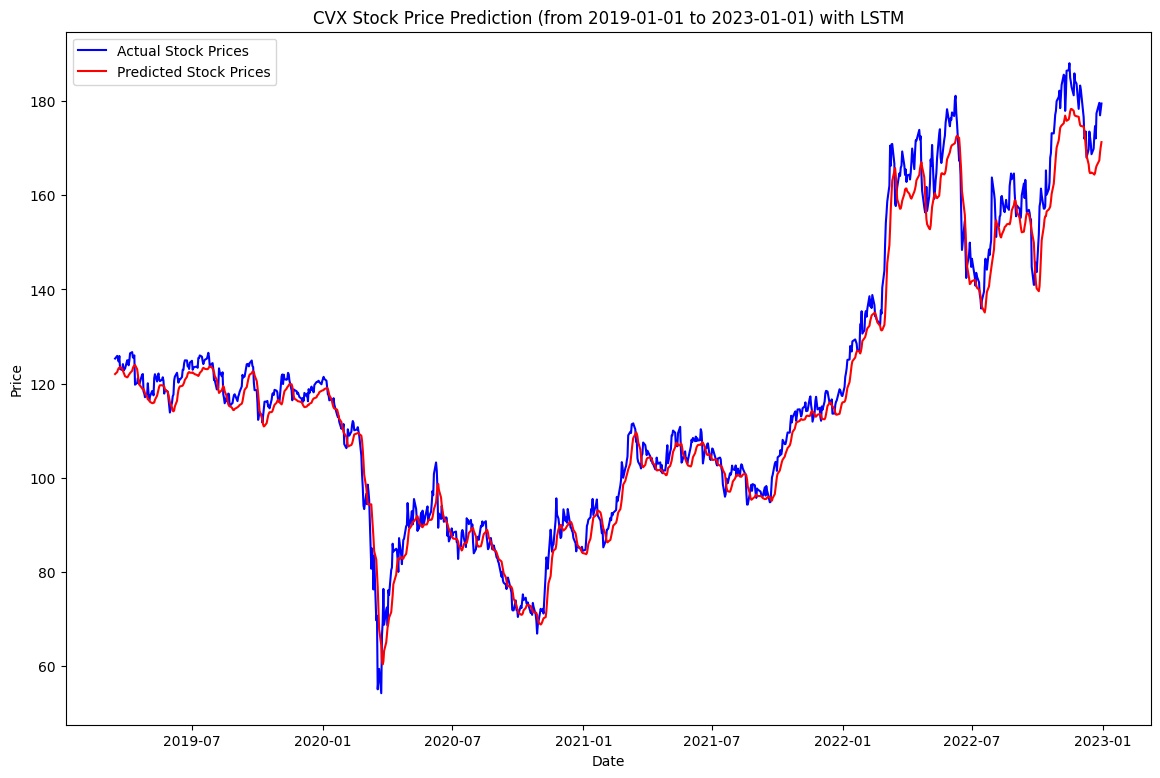

In [ ]:
plot(test_start_date, test_end_date, predicted_prices, actual_prices)

In [ ]:
mse(test_start_date, test_end_date, predicted_prices, actual_prices)

Mean Squared Error: 21.9069


Epoch 1/15, Training Loss: 0.0200
Epoch 2/15, Training Loss: 0.0004
Epoch 3/15, Training Loss: 0.0003
Epoch 4/15, Training Loss: 0.0003
Epoch 5/15, Training Loss: 0.0003
Epoch 6/15, Training Loss: 0.0003
Epoch 7/15, Training Loss: 0.0002
Epoch 8/15, Training Loss: 0.0002
Epoch 9/15, Training Loss: 0.0002
Epoch 10/15, Training Loss: 0.0002
Epoch 11/15, Training Loss: 0.0002
Epoch 12/15, Training Loss: 0.0002
Epoch 13/15, Training Loss: 0.0002
Epoch 14/15, Training Loss: 0.0002
Epoch 15/15, Training Loss: 0.0002


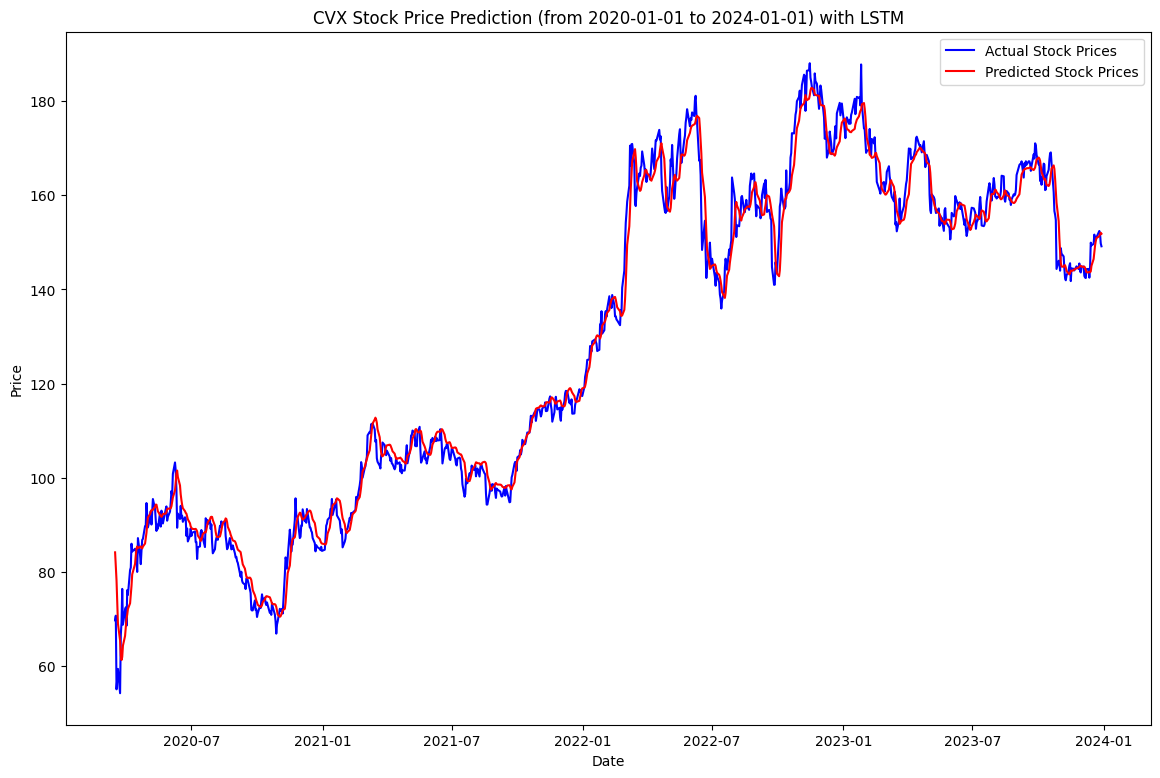

Mean Squared Error: 15.5535
Epoch 1/15, Training Loss: 0.0124
Epoch 2/15, Training Loss: 0.0003
Epoch 3/15, Training Loss: 0.0003
Epoch 4/15, Training Loss: 0.0002
Epoch 5/15, Training Loss: 0.0002
Epoch 6/15, Training Loss: 0.0002
Epoch 7/15, Training Loss: 0.0002
Epoch 8/15, Training Loss: 0.0002
Epoch 9/15, Training Loss: 0.0002
Epoch 10/15, Training Loss: 0.0002
Epoch 11/15, Training Loss: 0.0002
Epoch 12/15, Training Loss: 0.0002
Epoch 13/15, Training Loss: 0.0002
Epoch 14/15, Training Loss: 0.0001
Epoch 15/15, Training Loss: 0.0001


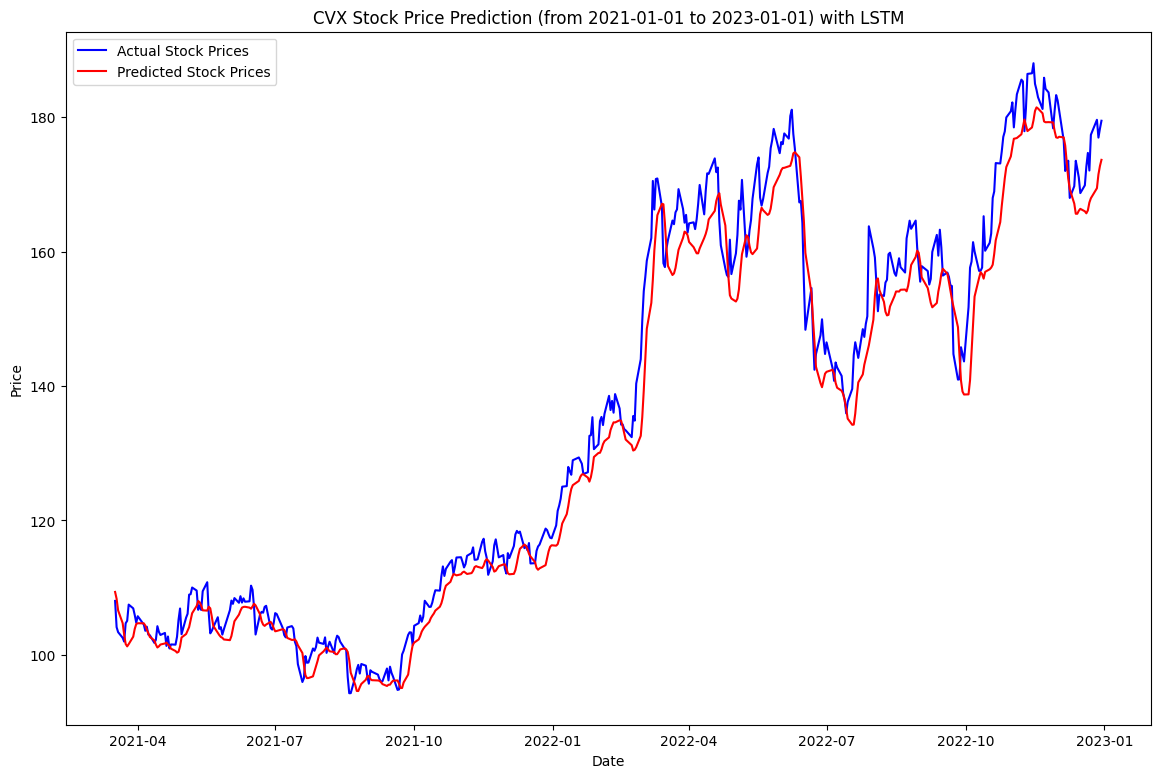

Mean Squared Error: 24.8039
Epoch 1/15, Training Loss: 0.0195
Epoch 2/15, Training Loss: 0.0003
Epoch 3/15, Training Loss: 0.0003
Epoch 4/15, Training Loss: 0.0003
Epoch 5/15, Training Loss: 0.0003
Epoch 6/15, Training Loss: 0.0003
Epoch 7/15, Training Loss: 0.0002
Epoch 8/15, Training Loss: 0.0002
Epoch 9/15, Training Loss: 0.0002
Epoch 10/15, Training Loss: 0.0002
Epoch 11/15, Training Loss: 0.0002
Epoch 12/15, Training Loss: 0.0002
Epoch 13/15, Training Loss: 0.0002
Epoch 14/15, Training Loss: 0.0002
Epoch 15/15, Training Loss: 0.0002


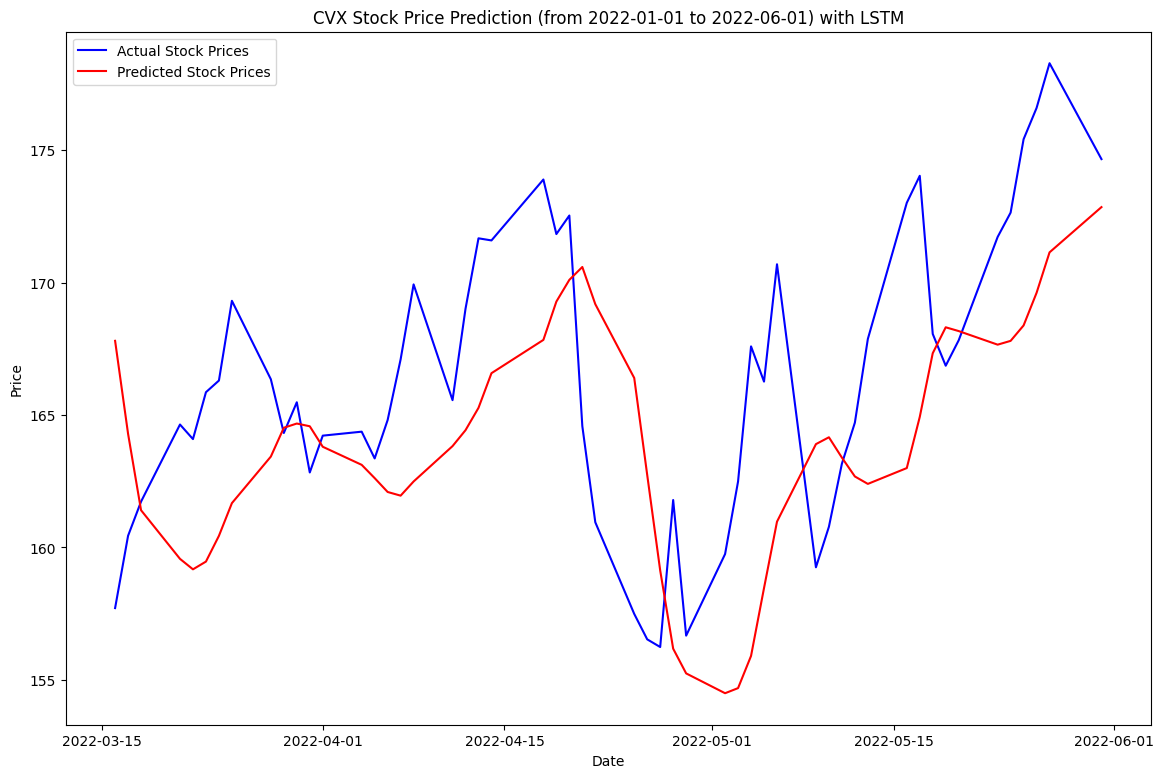

Mean Squared Error: 30.8002


In [ ]:
test_start_dates = ['2020-01-01', '2021-01-01', '2022-01-01']
test_end_dates = ['2024-01-01', '2023-01-01', '2022-06-01']
for test_start_date, test_end_date in zip(test_start_dates, test_end_dates):
  train_loader, test_loader, scaler, test=loadataset(test_start_date, test_end_date)
  model=train(test_start_date, test_end_date, train_loader, test_loader)
  predicted_prices, actual_prices=predict(test_start_date, test_end_date, train_loader, test_loader, model, scaler)
  plot(test_start_date, test_end_date, predicted_prices, actual_prices)
  mse(test_start_date, test_end_date, predicted_prices, actual_prices)

In [ ]:
def main(test_start_dates, test_end_dates):
  for test_start_date, test_end_date in zip(test_start_dates, test_end_dates):
    train_loader, test_loader, scaler, test=loadataset(test_start_date, test_end_date)
    model=train(test_start_date, test_end_date, train_loader, test_loader)
    predicted_prices, actual_prices=predict(test_start_date, test_end_date, train_loader, test_loader, model, scaler)
    plot(test_start_date, test_end_date, predicted_prices, actual_prices)
    mse(test_start_date, test_end_date, predicted_prices, actual_prices)

In [ ]:
test_start_dates1 = ['2022-01-01','2022-01-01']
test_end_dates1 = ['2022-06-15', '2022-01-02']
main(test_start_dates1, test_end_dates1)